In [72]:
import os
import numpy as np
import cv2
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import random  # For shuffling the file list


In [73]:
# Paths to training and test images
train_dir = 'D:\\cat and dog\\train\\'
test_dir = 'D:\\cat and dog\\test1\\'
sample_submission_path = 'D:\\cat and dog\\sampleSubmission.csv'

# Define parameters
IMG_SIZE = (128, 128)  # Resize images for faster training with better detail
MAX_IMAGES = 10000      # Limit number of images for faster testing

# Load and preprocess images
def load_images(path, is_train=True, max_images=MAX_IMAGES):
    images = []
    labels = []
    
    # Shuffle image filenames to ensure a mix of cats and dogs
    file_list = os.listdir(path)
    random.shuffle(file_list)
    
    for i, filename in enumerate(file_list):
        if i >= max_images:  # Limit the number of images
            break
        img_path = os.path.join(path, filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img, IMG_SIZE)
        images.append(img)

        if is_train:
            # Assign labels: 0 for cats, 1 for dogs
            if 'cat' in filename:
                labels.append(0)  # Cat
            else:
                labels.append(1)  # Dog

    print(f"Loaded {len(images)} images from {path}")
    if is_train:
        return np.array(images), np.array(labels)
    else:
        return np.array(images), None

# Load training images
print("Loading training images...")
X, y = load_images(train_dir, is_train=True, max_images=MAX_IMAGES)

# Ensure that both classes are present
print(f"Number of cats: {sum(y == 0)}, Number of dogs: {sum(y == 1)}")

Loading training images...
Loaded 10000 images from D:\cat and dog\train\
Number of cats: 4967, Number of dogs: 5033


In [74]:
# Normalize pixel values
X = X / 255.0

# Flatten the images
X = X.reshape(X.shape[0], -1)  # Reshape to (number_of_samples, flattened_image_size)

# Check data shape
print(f"Training data shape: {X.shape}, Labels shape: {y.shape}")

Training data shape: (10000, 49152), Labels shape: (10000,)


In [75]:
# Stratified split for maintaining balance
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, valid_index in sss.split(X, y):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

# Check label distribution in training and validation sets
print("Training set label distribution:", np.bincount(y_train))
print("Validation set label distribution:", np.bincount(y_valid))


Training set label distribution: [3974 4026]
Validation set label distribution: [ 993 1007]


In [76]:
# Train the SVM Classifier
print("Training the SVM Classifier...")
svm_classifier = svm.SVC(kernel='linear', C=1.0, random_state=42)
svm_classifier.fit(X_train, y_train)
print("Training complete.")


Training the SVM Classifier...
Training complete.


In [77]:
# Evaluate the classifier on the validation set
print("Evaluating on the validation set...")
y_valid_pred = svm_classifier.predict(X_valid)

# Evaluation metrics
print("Confusion Matrix:\n", confusion_matrix(y_valid, y_valid_pred))
print("\nClassification Report:\n", classification_report(y_valid, y_valid_pred))

Evaluating on the validation set...
Confusion Matrix:
 [[619 374]
 [538 469]]

Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.62      0.58       993
           1       0.56      0.47      0.51      1007

    accuracy                           0.54      2000
   macro avg       0.55      0.54      0.54      2000
weighted avg       0.55      0.54      0.54      2000



In [78]:
# Load test images
print("Loading test images...")
X_test, _ = load_images(test_dir, is_train=False, max_images=MAX_IMAGES)
X_test = X_test / 255.0  # Normalize test images
X_test = X_test.reshape(X_test.shape[0], -1)

Loading test images...
Loaded 10000 images from D:\cat and dog\test1\


In [ ]:
# Make predictions on the test set

print("Making predictions on the test set...")
test_predictions = svm_classifier.predict(X_test)



In [ ]:

print("Loading sample submission file...")
sample_submission = pd.read_csv(sample_submission_path)

# Ensure the number of predictions matches the number of rows in the submission file
if len(test_predictions) == len(sample_submission):
    sample_submission['label'] = test_predictions
else:
    sample_submission = sample_submission.iloc[:len(test_predictions)]
    sample_submission['label'] = test_predictions

# Save the submission file
submission_path = 'submission.csv'
sample_submission.to_csv(submission_path, index=False)
print(f"Submission file created: '{submission_path}'")


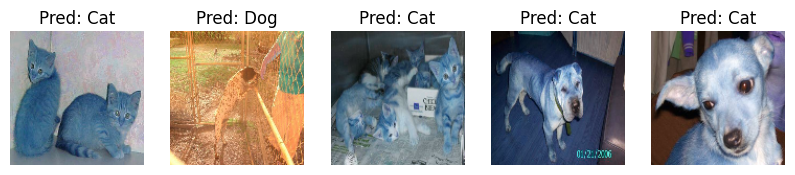

In [68]:

# Visualize some predictions
def visualize_predictions(X_test, y_pred, num_images=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(X_test[i].reshape(IMG_SIZE[0], IMG_SIZE[1], 3))
        plt.axis('off')
        plt.title(f'Pred: {"Dog" if y_pred[i] == 1 else "Cat"}')
    plt.show()

# Uncomment below to visualize predictions if needed
visualize_predictions(X_test, test_predictions)
